# Logistic Regression

Despite its name, logistic regression is a **classification** algorithm — not regression. The name comes from the logistic (sigmoid) function it uses internally.

Classification is everywhere: spam detection, medical diagnosis, fraud detection, churn prediction. This is often what people actually need when they say "I want to predict something."

**What we'll cover:**
- From regression to classification
- The sigmoid function
- Binary cross-entropy loss
- Gradient descent for classification
- Evaluation metrics
- Multi-class extension

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

## The Problem: Classification

In linear regression, we predicted continuous values (salary). Now we want to predict **categories**.

Example: Will a loan applicant default?
- Input: income, debt ratio, credit score
- Output: **yes** or **no** (not a number)

This is **binary classification** — two possible outcomes.

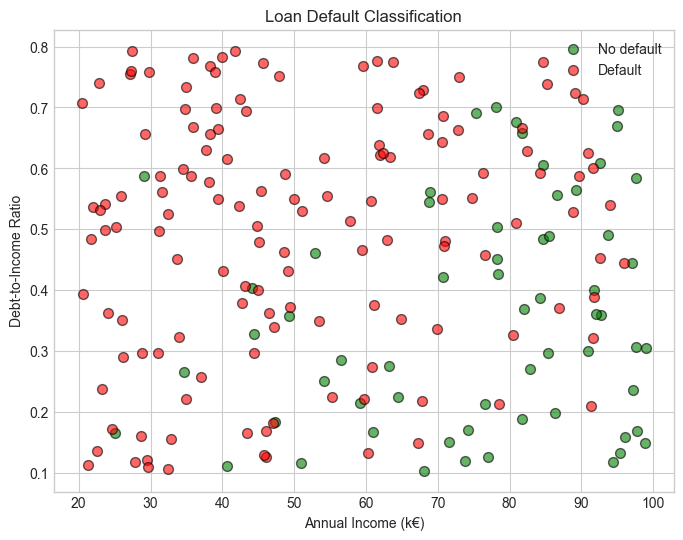

Dataset: 200 applicants
  No default: 61
  Default: 139


In [4]:
# Generate synthetic loan data
n_samples = 200

# Features: income (k€) and debt-to-income ratio
income = np.random.uniform(20, 100, n_samples)
debt_ratio = np.random.uniform(0.1, 0.8, n_samples)

# True relationship: higher income and lower debt → less likely to default
z = -2 + 0.05 * income - 4 * debt_ratio + np.random.normal(0, 0.5, n_samples)
prob_no_default = 1 / (1 + np.exp(-z))
default = (np.random.random(n_samples) > prob_no_default).astype(int)

# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(income[default==0], debt_ratio[default==0], 
            c='green', label='No default', s=50, alpha=0.6, edgecolors='k')
plt.scatter(income[default==1], debt_ratio[default==1], 
            c='red', label='Default', s=50, alpha=0.6, edgecolors='k')
plt.xlabel('Annual Income (k€)')
plt.ylabel('Debt-to-Income Ratio')
plt.title('Loan Default Classification')
plt.legend()
plt.show()

print(f"Dataset: {n_samples} applicants")
print(f"  No default: {np.sum(default==0)}")
print(f"  Default: {np.sum(default==1)}")

## Why Not Just Use Linear Regression?

You might think: just predict 0 or 1 with linear regression, then round.

Problems:
1. Linear regression outputs can be < 0 or > 1 (not valid probabilities)
2. Squared error doesn't make sense for classification
3. Outliers distort the fit badly

We need a function that:
- Always outputs values between 0 and 1
- Can be interpreted as probability
- Has nice mathematical properties for optimization

## The Sigmoid Function

The sigmoid (or logistic) function maps any real number to the range (0, 1):

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

The logistic regression model is:

$$P(y=1 | \mathbf{x}) = \sigma(\mathbf{w}^T \mathbf{x} + b) = \frac{1}{1 + e^{-(\mathbf{w}^T \mathbf{x} + b)}}$$

We predict class 1 if this probability ≥ 0.5, else class 0.

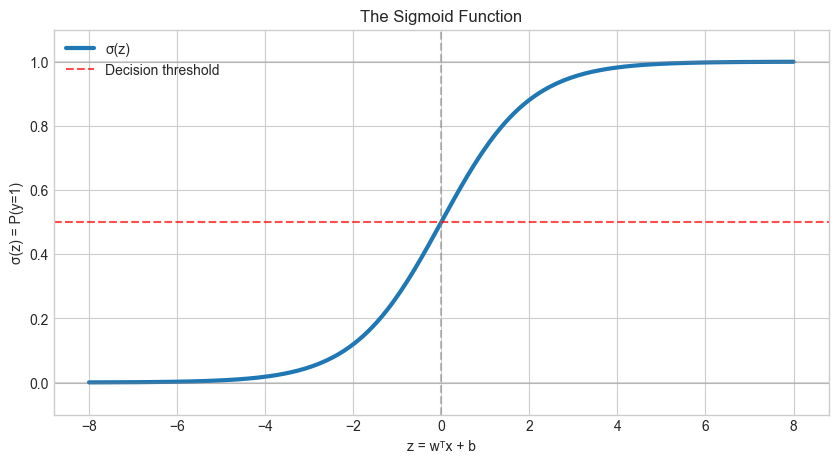

Sigmoid properties:
  σ(-∞) → 0
  σ(0)  = 0.5
  σ(+∞) → 1
  Always between 0 and 1 ✓


In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-8, 8, 200)

plt.figure(figsize=(10, 5))
plt.plot(z, sigmoid(z), linewidth=3, label='σ(z)')
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Decision threshold')
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
plt.axhline(y=1, color='gray', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

plt.xlabel('z = wᵀx + b')
plt.ylabel('σ(z) = P(y=1)')
plt.title('The Sigmoid Function')
plt.legend()
plt.ylim(-0.1, 1.1)
plt.show()

print("Sigmoid properties:")
print(f"  σ(-∞) → 0")
print(f"  σ(0)  = 0.5")
print(f"  σ(+∞) → 1")
print(f"  Always between 0 and 1 ✓")

## Training the Model

How do we train the weights of a logistic regression model?

Assume we have a dataset of $n$ applicants with their true labels (default yes/default no):
$$[(\mathbf{X}_1, Y_1), (\mathbf{X}_2, Y_2), ..., (\mathbf{X}_n, Y_n)]$$

### Maximum Likelihood

We can write an expression for the total probability of our dataset:

$$\text{Probability} = \prod_{i=1}^{n} F(\mathbf{X}_i)^{Y_i} (1 - F(\mathbf{X}_i))^{1-Y_i}$$

**Goal:** Maximize this probability (or equivalently, minimize the negative log-likelihood)

### Loss Function: Binary Cross-Entropy

In practice, we minimize the **binary cross-entropy loss**:

$$L = -\frac{1}{n} \sum_{i=1}^{n} [Y_i \log(F(\mathbf{X}_i)) + (1-Y_i) \log(1-F(\mathbf{X}_i))]$$

### Optimization

We use **gradient descent**:
1. Compute derivative with respect to weights
2. Update weights: $A := A - \alpha \nabla L$
3. Repeat until convergence

This is analogous to the procedure for linear regression!

## Training with Gradient Descent

Like linear regression, we use gradient descent to find optimal weights.

The gradients of binary cross-entropy with respect to weights:

$$\frac{\partial L}{\partial w_j} = \frac{1}{n} \sum_{i=1}^{n} (\hat{p}_i - y_i) x_{ij}$$

$$\frac{\partial L}{\partial b} = \frac{1}{n} \sum_{i=1}^{n} (\hat{p}_i - y_i)$$

Remarkably simple — same form as linear regression, just with sigmoid predictions.

In [14]:
class LogisticRegressionGD:
    """Logistic regression from scratch using gradient descent."""
    
    def __init__(self, learning_rate=0.1, n_iterations=1000):
        self.lr = learning_rate
        self.n_iter = n_iterations
        self.weights = None
        self.bias = None
        self.loss_history = []
        
    def sigmoid(self, z):
        # Clip to avoid overflow
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Initialize weights
        self.weights = np.zeros(n_features)
        self.bias = 0.0
        
        for _ in range(self.n_iter):
            # Forward pass
            z = X @ self.weights + self.bias
            p = self.sigmoid(z)
            
            # Compute loss (add small epsilon for numerical stability)
            eps = 1e-15
            loss = -np.mean(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps))
            self.loss_history.append(loss)
            
            # Gradients
            error = p - y
            dw = (1 / n_samples) * (X.T @ error)
            db = (1 / n_samples) * np.sum(error)
            
            # Update
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
            
        return self
    
    def predict_proba(self, X):
        z = X @ self.weights + self.bias
        return self.sigmoid(z)
    
    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

In [17]:
# Prepare data
X = np.column_stack([income, debt_ratio])
y = default

# Standardize features (important for gradient descent)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train
model = LogisticRegressionGD(learning_rate=0.5, n_iterations=500)
model.fit(X_scaled, y)

# Evaluate
y_pred = model.predict(X_scaled)
accuracy = np.mean(y_pred == y)

print(f"Training complete")
print(f"  Final loss: {model.loss_history[-1]:.4f}")
print(f"  Accuracy: {accuracy:.1%}")

Training complete
  Final loss: 0.4262
  Accuracy: 79.5%


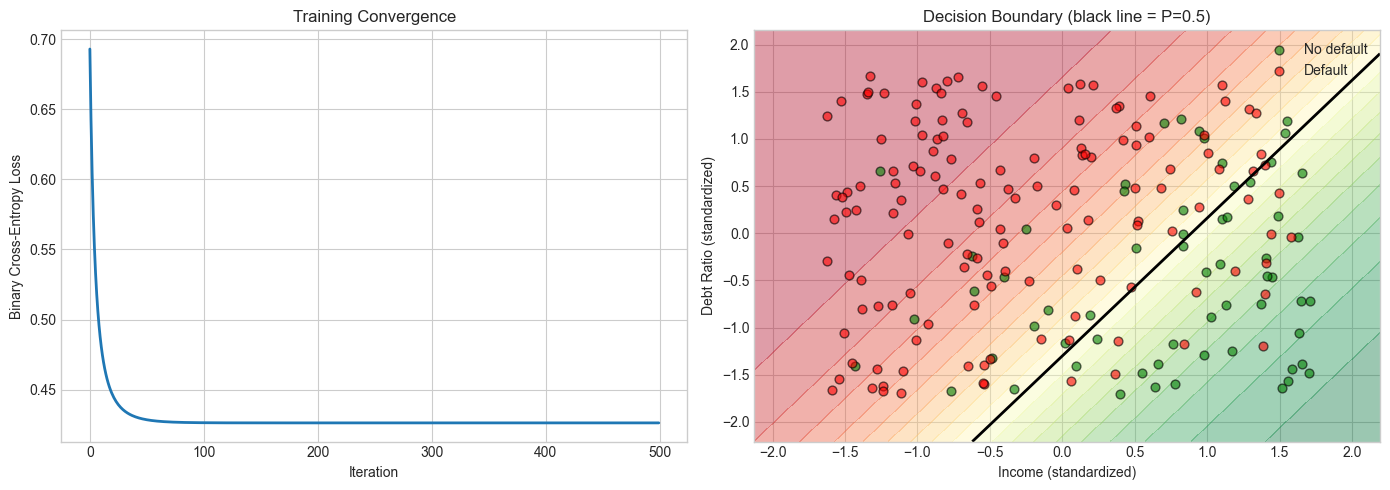

In [24]:
# Visualize training and decision boundary
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(model.loss_history, linewidth=2)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Binary Cross-Entropy Loss')
axes[0].set_title('Training Convergence')

# Decision boundary
h = 0.02
x_min, x_max = X_scaled[:, 0].min() - 0.5, X_scaled[:, 0].max() + 0.5
y_min, y_max = X_scaled[:, 1].min() - 0.5, X_scaled[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

axes[1].contourf(xx, yy, Z, alpha=0.4, cmap='RdYlGn_r', levels=20)
axes[1].contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
axes[1].scatter(X_scaled[y==0, 0], X_scaled[y==0, 1], c='green', 
                label='No default', s=40, alpha=0.6, edgecolors='k')
axes[1].scatter(X_scaled[y==1, 0], X_scaled[y==1, 1], c='red', 
                label='Default', s=40, alpha=0.6, edgecolors='k')
axes[1].set_xlabel('Income (standardized)')
axes[1].set_ylabel('Debt Ratio (standardized)')
axes[1].set_title('Decision Boundary (black line = P=0.5)')
axes[1].legend()

plt.tight_layout()
plt.show()

## Evaluation Metrics

Accuracy alone can be misleading, especially with imbalanced classes. Key metrics:

| Metric | Formula | Meaning |
|--------|---------|--------|
| **Precision** | TP / (TP + FP) | Of predicted positives, how many are correct? |
| **Recall** | TP / (TP + FN) | Of actual positives, how many did we catch? |
| **F1 Score** | 2 × (P × R) / (P + R) | Harmonic mean of precision and recall |

The **confusion matrix** shows the full picture of predictions vs reality.

In [27]:
# Train with sklearn for proper evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

model = LogisticRegressionGD(learning_rate=0.5, n_iterations=500)
model.fit(X_scaled, y)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

print("Classification Report:")
print("=" * 50)
print(classification_report(y_test, y_pred, target_names=['No Default', 'Default']))

Classification Report:
              precision    recall  f1-score   support

  No Default       0.56      0.42      0.48        12
     Default       0.77      0.86      0.81        28

    accuracy                           0.72        40
   macro avg       0.66      0.64      0.64        40
weighted avg       0.71      0.72      0.71        40



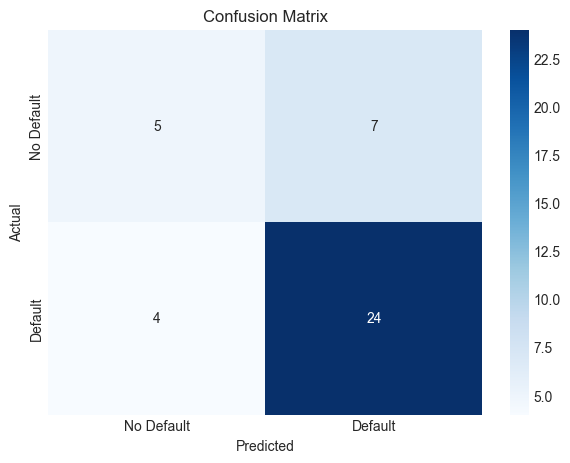

True Negatives: 5 (correctly predicted no default)
False Positives: 7 (predicted default, but didn't)
False Negatives: 4 (predicted no default, but did)
True Positives: 24 (correctly predicted default)


In [28]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn} (correctly predicted no default)")
print(f"False Positives: {fp} (predicted default, but didn't)")
print(f"False Negatives: {fn} (predicted no default, but did)")
print(f"True Positives: {tp} (correctly predicted default)")

## Threshold Tuning

The default threshold of 0.5 isn't always optimal. Depending on the cost of errors:

- **Lower threshold** → More positive predictions → Higher recall, lower precision
- **Higher threshold** → Fewer positive predictions → Lower recall, higher precision

In loan default prediction, missing a default (false negative) is usually more costly than a false positive. 

It follows a plot of how precision and recall changes at different thresholds (this is known as the PR-Area Under the Curve graph). In the next notebooks we will also introduce the ROC-AUC, which is another plot you can use to decide what threshold to use. 

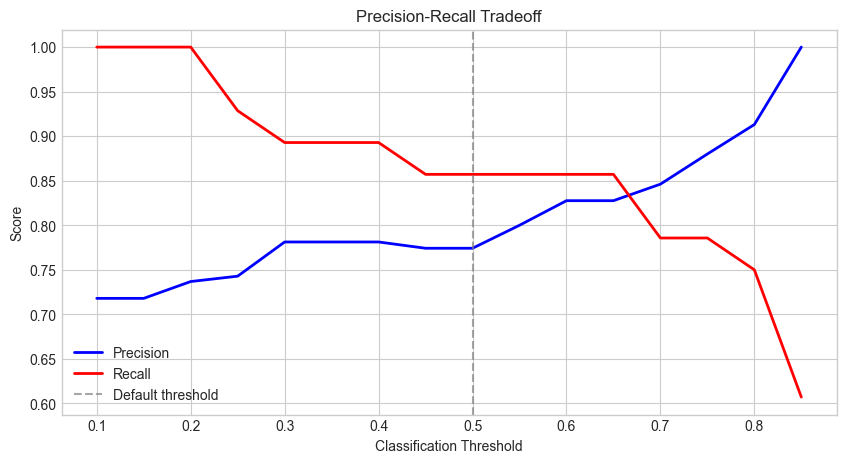

Lower threshold → catch more defaults (higher recall)
Higher threshold → fewer false alarms (higher precision)


In [30]:
# Effect of different thresholds
from sklearn.metrics import precision_score, recall_score

thresholds = np.arange(0.1, 0.9, 0.05)
precisions = []
recalls = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred_t, zero_division=0))
    recalls.append(recall_score(y_test, y_pred_t, zero_division=0))

plt.figure(figsize=(10, 5))
plt.plot(thresholds, precisions, 'b-', linewidth=2, label='Precision')
plt.plot(thresholds, recalls, 'r-', linewidth=2, label='Recall')
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, label='Default threshold')
plt.xlabel('Classification Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Tradeoff')
plt.legend()
plt.show()

print("Lower threshold → catch more defaults (higher recall)")
print("Higher threshold → fewer false alarms (higher precision)")

## Interpreting Coefficients

One advantage of logistic regression: coefficients are interpretable.

For a coefficient $w_j$:
- Positive → increases probability of class 1
- Negative → decreases probability of class 1
- Magnitude → strength of effect

In [39]:
feature_names = ['Income (standardized)', 'Debt Ratio (standardized)']

print("Coefficients:")
for name, coef in zip(feature_names, model_sk.coef_[0]):
    direction = "increases" if coef > 0 else "decreases"
    print(f"\n{name}: {coef:.3f}")
    print(f"-> Higher {name.split()[0].lower()} {direction} default probability")

print(f"\nIntercept (bias): {model_sk.intercept_[0]:.3f}")

Coefficients:

Income (standardized): -1.351
-> Higher income decreases default probability

Debt Ratio (standardized): 1.058
-> Higher debt increases default probability

Intercept (bias): 1.298


## Real Example: Breast Cancer Diagnosis

Let's apply logistic regression to a real medical dataset.

In [40]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X_cancer = cancer.data
y_cancer = cancer.target  # 0 = malignant, 1 = benign

print(f"Dataset: {cancer.DESCR.split(chr(10))[0]}")
print(f"Samples: {len(X_cancer)}")
print(f"Features: {len(cancer.feature_names)}")
print(f"\nClass distribution:")
print(f"  Malignant: {np.sum(y_cancer==0)} ({np.mean(y_cancer==0):.1%})")
print(f"  Benign: {np.sum(y_cancer==1)} ({np.mean(y_cancer==1):.1%})")

Dataset: .. _breast_cancer_dataset:
Samples: 569
Features: 30

Class distribution:
  Malignant: 212 (37.3%)
  Benign: 357 (62.7%)


In [41]:
# Train and evaluate
X_train, X_test, y_train, y_test = train_test_split(
    X_cancer, y_cancer, test_size=0.2, random_state=42, stratify=y_cancer
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_cancer = LogisticRegression(max_iter=5000, random_state=42)
model_cancer.fit(X_train_scaled, y_train)

y_pred = model_cancer.predict(X_test_scaled)
y_proba = model_cancer.predict_proba(X_test_scaled)[:, 1]

print("Cancer Diagnosis Results:")
print("=" * 50)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.1%}")
print(f"AUC: {roc_auc_score(y_test, y_proba):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Malignant', 'Benign']))

Cancer Diagnosis Results:
Accuracy: 98.2%
AUC: 0.995

Classification Report:
              precision    recall  f1-score   support

   Malignant       0.98      0.98      0.98        42
      Benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



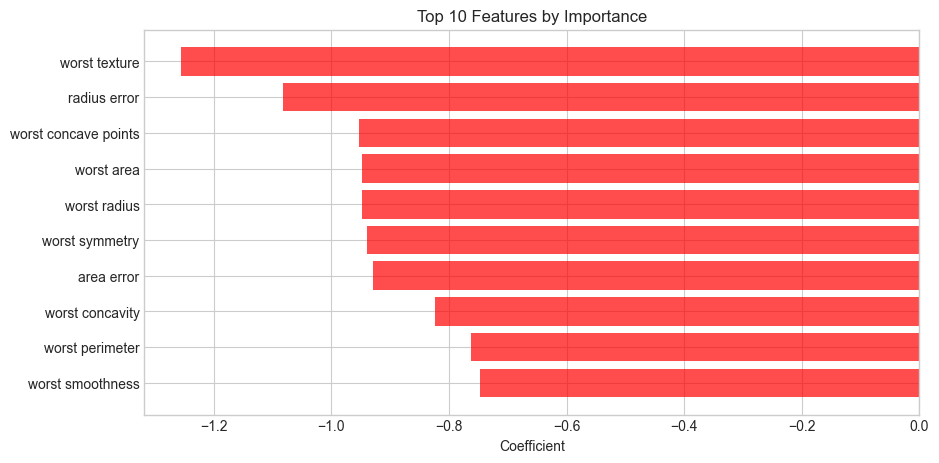

Green = associated with benign
Red = associated with malignant


In [42]:
# Most important features
importance = np.abs(model_cancer.coef_[0])
top_idx = np.argsort(importance)[-10:][::-1]

plt.figure(figsize=(10, 5))
colors = ['green' if model_cancer.coef_[0][i] > 0 else 'red' for i in top_idx]
plt.barh([cancer.feature_names[i] for i in top_idx], 
         [model_cancer.coef_[0][i] for i in top_idx],
         color=colors, alpha=0.7)
plt.xlabel('Coefficient')
plt.title('Top 10 Features by Importance')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.gca().invert_yaxis()
plt.show()

print("Green = associated with benign")
print("Red = associated with malignant")

## Multi-Class Classification

Logistic regression extends to more than 2 classes using:

1. **One-vs-Rest (OvR)**: Train K binary classifiers, pick highest confidence
2. **Multinomial (Softmax)**: Direct multi-class formulation

The softmax function generalizes sigmoid to K classes:

$$P(y=k | \mathbf{x}) = \frac{e^{\mathbf{w}_k^T \mathbf{x}}}{\sum_{j=1}^{K} e^{\mathbf{w}_j^T \mathbf{x}}}$$

All probabilities sum to 1.

In [45]:
from sklearn.datasets import load_iris

iris = load_iris()
X_iris, y_iris = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(
    X_iris, y_iris, test_size=0.2, random_state=42, stratify=y_iris
)

# Multinomial logistic regression
model_multi = LogisticRegression(max_iter=1000) # Nowadays logrec is by default multinomial. OneVsRestClassifier(LogisticRegression() to do OVS
model_multi.fit(X_train, y_train)

y_pred = model_multi.predict(X_test)

print(f"Iris Classification (3 classes)")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.1%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=iris.target_names))

Iris Classification (3 classes)
Accuracy: 96.7%

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



## Summary

| Concept | Description |
|---------|-------------|
| **Model** | $P(y=1) = \sigma(\mathbf{w}^T \mathbf{x} + b)$ where $\sigma(z) = \frac{1}{1+e^{-z}}$ |
| **Decision rule** | Predict 1 if $P \geq 0.5$, else 0 |
| **Loss function** | Binary cross-entropy: $-[y\log(p) + (1-y)\log(1-p)]$ |
| **Training** | Gradient descent (same form as linear regression) |
| **Output** | Probabilities, not just labels |
| **Multi-class** | Softmax generalization |

**When to use:**
- Binary or multi-class classification
- Need probability estimates
- Want interpretable coefficients
- Linear decision boundary is adequate
- Fast baseline model

**When to consider alternatives:**
- Complex non-linear boundaries → tree models, neural networks
- High-dimensional sparse data → Naive Bayes, linear SVM
- Need to capture feature interactions → tree ensembles